In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import adjusted_rand_score
import random
from sklearn.utils import resample
from scipy.stats import entropy
from sklearn.mixture import GaussianMixture

In [3]:
#pip install bioinfokit

##Exploring Data

In [5]:
df = pd.read_csv("mcdonalds.csv")
df.head()

,yummy,convenient,spicy,fattening,greasy,fast,cheap,tasty,expensive,healthy,disgusting,Like,Age,VisitFrequency,Gender
0,No,Yes,No,Yes,No,Yes,Yes,No,Yes,No,No,-3,61,Every three months,Female
1,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,No,No,+2,51,Every three months,Female
2,No,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,No,+1,62,Every three months,Female
3,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,No,No,Yes,+4,69,Once a week,Female
4,No,Yes,No,Yes,Yes,Yes,Yes,No,No,Yes,No,+2,49,Once a month,Male


In [6]:
df.shape

(1453, 15)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1453 entries, 0 to 1452
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   yummy           1453 non-null   object
 1   convenient      1453 non-null   object
 2   spicy           1453 non-null   object
 3   fattening       1453 non-null   object
 4   greasy          1453 non-null   object
 5   fast            1453 non-null   object
 6   cheap           1453 non-null   object
 7   tasty           1453 non-null   object
 8   expensive       1453 non-null   object
 9   healthy         1453 non-null   object
 10  disgusting      1453 non-null   object
 11  Like            1453 non-null   object
 12  Age             1453 non-null   int64 
 13  VisitFrequency  1453 non-null   object
 14  Gender          1453 non-null   object
dtypes: int64(1), object(14)
memory usage: 170.4+ KB


In [8]:
MD_x = df.iloc[:, 0:11].to_numpy()
MD_x = (MD_x == "Yes").astype(int)
means = np.round(MD_x.mean(axis=0), 2)
print(means)

[0.55 0.91 0.09 0.87 0.53 0.9  0.6  0.64 0.36 0.2  0.24]


In [9]:
pca = PCA()
MD_pca = pca.fit(MD_x)

In [10]:
std_dev = np.sqrt(pca.explained_variance_)
prop_var = pca.explained_variance_ratio_
cum_prop_var = np.cumsum(prop_var)
pca_summary = pd.DataFrame({
    'Standard Deviation': np.round(std_dev,4),
    'Proportion of Variance': np.round(prop_var,4),
    'Cumulative Proportion': np.round(cum_prop_var,4)
})
pca_summary

,Standard Deviation,Proportion of Variance,Cumulative Proportion
0,0.7570,0.2994,0.2994
1,0.6075,0.1928,0.4922
2,0.5046,0.1330,0.6253
3,0.3988,0.0831,0.7084
4,0.3374,0.0595,0.7679
5,0.3103,0.0503,0.8182
6,0.2897,0.0438,0.8620
7,0.2751,0.0395,0.9016
8,0.2653,0.0368,0.9383
9,0.2488,0.0324,0.9707


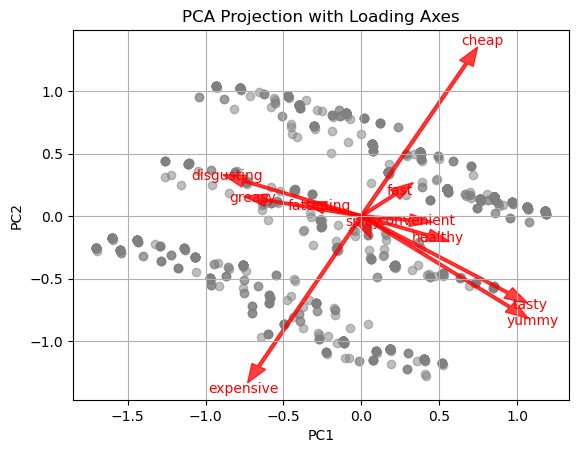

In [11]:
MD_pca_projection = MD_pca.transform(MD_x)
plt.scatter(MD_pca_projection[:, 0], MD_pca_projection[:, 1], color="grey", alpha=0.5)
plt.xlabel("PC1")
plt.ylabel("PC2")
scaling_factor = 2 
for i in range(MD_pca.components_.shape[1]):
    pc1, pc2 = MD_pca.components_[0, i] * scaling_factor, MD_pca.components_[1, i] * scaling_factor
    plt.arrow(0, 0, pc1, pc2, color='red', width=0.02, head_width=0.1, alpha=0.75)
    plt.text(pc1 * 1.15, pc2 * 1.15, df.columns.values[i], color='red', ha='center', va='center')

plt.title("PCA Projection with Loading Axes")
plt.grid(True)
plt.show()


Usingk-Means


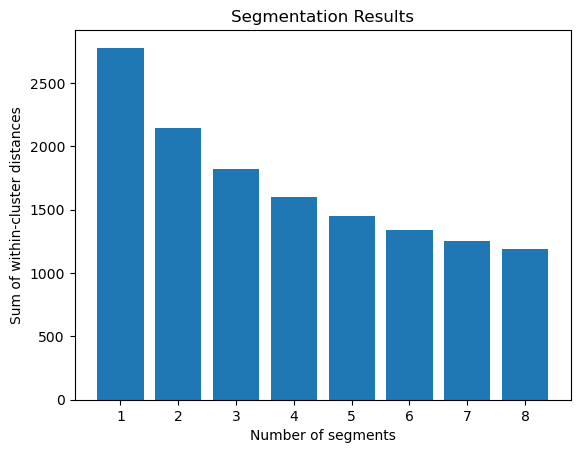

In [13]:
np.random.seed(1234)
cluster_range = range(1, 9)
within_cluster_distances = [] 
MD_km28 = {}
nrep = 10

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, n_init=nrep, random_state=1234)
    kmeans.fit(MD_x)
    within_cluster_distances.append(kmeans.inertia_)
    MD_km28[str(k)] = kmeans

plt.bar(cluster_range, within_cluster_distances) 
plt.xlabel("Number of segments")
plt.ylabel("Sum of within-cluster distances")
plt.title("Segmentation Results")
plt.show()



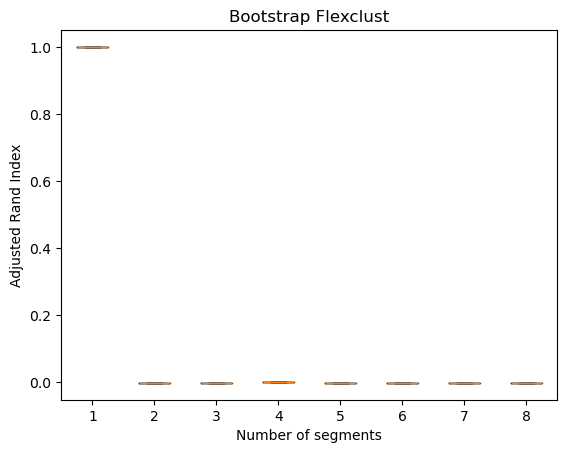

In [14]:
np.random.seed(1234)
cluster_range = range(1, 9)
nrep = 10
nboot = 100
adjusted_rand_index = []

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, n_init=nrep, random_state=1234)
    kmeans.fit(MD_x)
    true_labels = kmeans.labels_
    stability_scores = []
    for _ in range(nboot):
        bootstrap_sample = resample(MD_x, random_state=1234)
        kmeans_bootstrap = KMeans(n_clusters=k, n_init=nrep, random_state=1234)
        kmeans_bootstrap.fit(bootstrap_sample)
        cluster_labels = kmeans_bootstrap.predict(bootstrap_sample)
        stability_score = adjusted_rand_score(true_labels, cluster_labels)
        stability_scores.append(stability_score)
    adjusted_rand_index.append(stability_scores)
adjusted_rand_index = np.array(adjusted_rand_index).T
plt.boxplot(adjusted_rand_index, tick_labels=cluster_range, whis=10)
plt.xlabel("Number of segments")
plt.ylabel("Adjusted Rand Index")
plt.title("Bootstrap Flexclust")
plt.show()


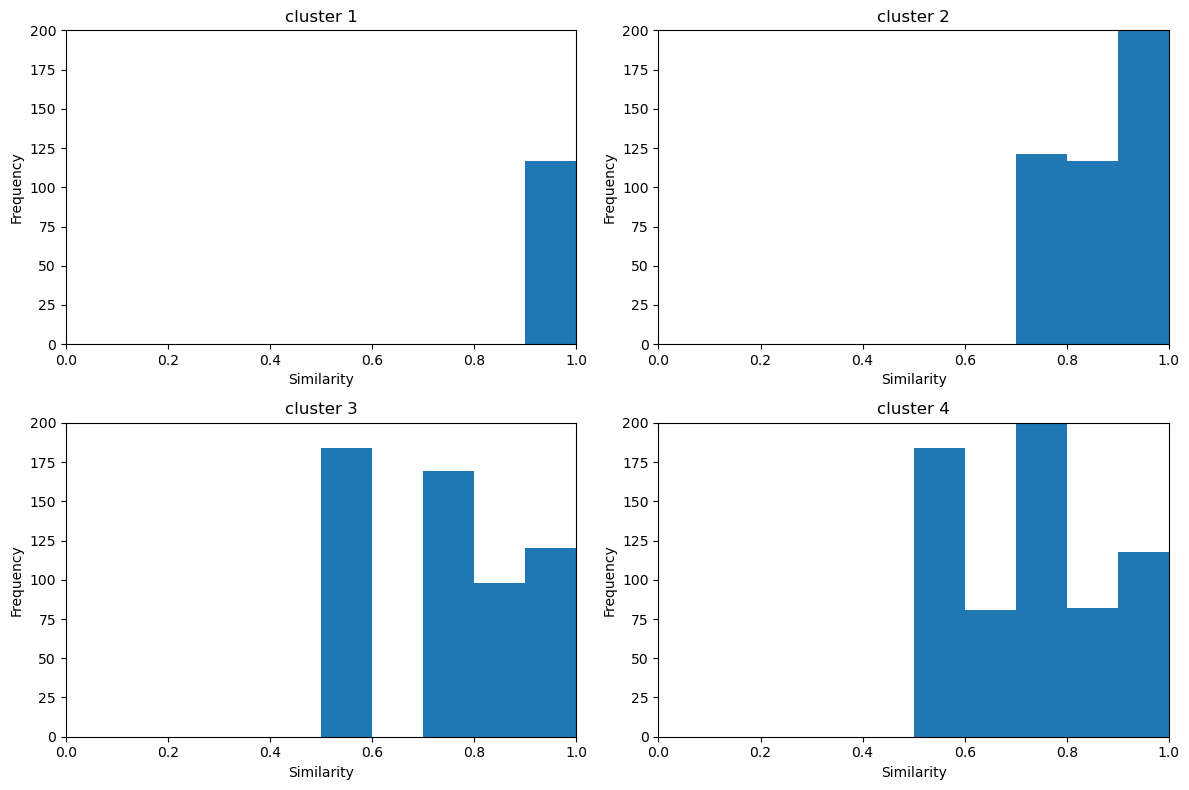

In [15]:
range_values = (0, 1)
num_bins = 10
max_frequency = 200

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

for i in range(1, 5):
    labels = MD_km28[str(i)].predict(MD_x)
    similarities = MD_km28[str(i)].transform(MD_x).min(axis=1)
    row = (i - 1) // 2
    col = (i - 1) % 2

    axs[row, col].hist(similarities, bins=num_bins, range=range_values)
    axs[row, col].set_xlabel('Similarity')
    axs[row, col].set_ylabel('Frequency')
    axs[row, col].set_title('cluster {}'.format(i))

    axs[row, col].set_xlim(range_values)
    axs[row, col].set_ylim(0, max_frequency)


    axs[row, col].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])

plt.tight_layout()
plt.show()

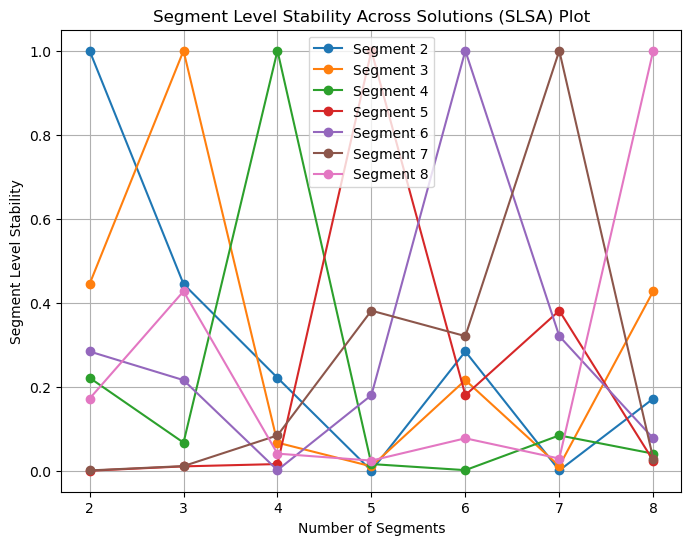

In [16]:
num_segments = range(2, 9)

segment_stability = []
for segment in range(2, 9):
    labels_segment = MD_km28[str(segment)].predict(MD_x)
    segment_stability.append(labels_segment)

plt.figure(figsize=(8, 6))
for i, segment in enumerate(range(2, 9)):
    plt.plot(num_segments, [np.mean(segment_stability[i] == labels) for labels in segment_stability], marker='o', label=f'Segment {segment}')

plt.xlabel('Number of Segments')
plt.ylabel('Segment Level Stability')
plt.title('Segment Level Stability Across Solutions (SLSA) Plot')
plt.xticks(num_segments)
plt.legend()
plt.grid(True)

plt.show()

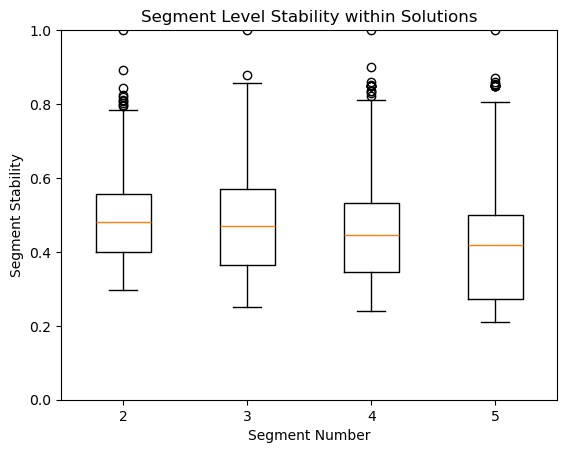

In [17]:
segment_solutions = ["2", "3", "4", "5"]
segment_labels = {}
segment_similarities = {}

for segment in segment_solutions:
    segment_labels[segment] = MD_km28[segment].predict(MD_x)
    segment_similarities[segment] = MD_km28[segment].transform(MD_x).min(axis=1)

segment_stability_values = []
for segment in segment_solutions:
    similarities = segment_similarities[segment]
    normalized_similarities = similarities / np.max(similarities) 
    segment_stability_values.append(normalized_similarities)

plt.boxplot(segment_stability_values, whis=1.5)
plt.xlabel("Segment Number")
plt.ylabel("Segment Stability")
plt.xticks(range(1, len(segment_solutions) + 1), segment_solutions)
plt.ylim(0, 1)
plt.title("Segment Level Stability within Solutions")

plt.show()

In [18]:
np.random.seed(1234)
k_values = range(2, 9)
MD_m28 = []

for k in k_values:
    model = KMeans(n_clusters=k, random_state=1234)
    model.fit(MD_x)
    iter_val = model.n_iter_
    converged = True
    k_val = k
    k0_val = k
    log_likelihood = -model.inertia_
    n_samples, _ = MD_x.shape
    aic = -2 * log_likelihood + 2 * k
    bic = -2 * log_likelihood + np.log(n_samples) * k
    labels = model.labels_
    counts = np.bincount(labels)
    probs = counts / float(counts.sum())
    class_entropy = entropy(probs)
    icl = bic - class_entropy
    
    MD_m28.append((iter_val, converged, k_val, k0_val, log_likelihood, aic, bic, icl))
MD_m28 = pd.DataFrame(MD_m28, columns=['iter', 'converged', 'k', 'k0', 'logLik', 'AIC', 'BIC', 'ICL'])

print(MD_m28)

   iter  converged  k  k0       logLik          AIC          BIC          ICL
0     7       True  2   2 -2205.739181  4415.478361  4426.041133  4425.376445
1     5       True  3   3 -1896.330266  3798.660532  3814.504689  3813.529671
2     9       True  4   4 -1603.913802  3215.827604  3236.953147  3235.627738
3     8       True  5   5 -1502.697153  3015.394306  3041.801234  3040.267284
4     4       True  6   6 -1356.136132  2724.272264  2755.960578  2754.217035
5     4       True  7   7 -1260.417450  2534.834901  2571.804601  2569.909768
6    13       True  8   8 -1202.154181  2420.308363  2462.559448  2460.553829


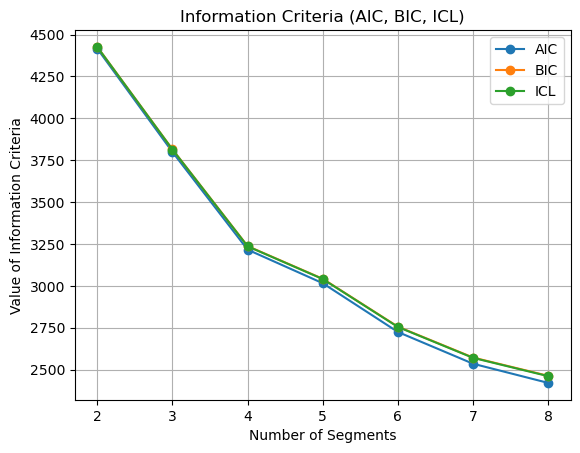

In [19]:
num_segments = MD_m28["k"]
AIC_values = MD_m28["AIC"]
BIC_values = MD_m28["BIC"]
ICL_values = MD_m28["ICL"]

plt.plot(num_segments, AIC_values, marker='o', label='AIC')
plt.plot(num_segments, BIC_values, marker='o', label='BIC')
plt.plot(num_segments, ICL_values, marker='o', label='ICL')

plt.xlabel('Number of Segments')
plt.ylabel('Value of Information Criteria')
plt.title('Information Criteria (AIC, BIC, ICL)')
plt.legend()
plt.grid(True)

plt.show()

In [20]:
k = 4
kmeans = KMeans(n_clusters=k, random_state=1234)
kmeans.fit(MD_x)
kmeans_clusters = kmeans.predict(MD_x)

gmm = GaussianMixture(n_components=k, random_state=1234)
gmm.fit(MD_x)
gmm_clusters = gmm.predict(MD_x)

results = pd.DataFrame({'kmeans': kmeans_clusters, 'mixture': gmm_clusters})

MD_m4 = MD_x[results['mixture'] == 3] 

k4_m4 = KMeans(n_clusters=k, random_state=1234)
k4_m4.fit(MD_m4)
k4_m4_clusters = k4_m4.predict(MD_m4)

results_m4 = pd.DataFrame({'kmeans': k4_m4_clusters, 'mixture': 3})

print(pd.crosstab(results['kmeans'], results['mixture']))
print(pd.crosstab(results['kmeans'], results_m4['kmeans']))

mixture    0    1    2    3
kmeans                     
0        546    0    1   33
1          0  213   11    4
2         46    3  265    8
3         29   38    0  256
kmeans   0   1   2   3
kmeans                
0       81  13  11  16
1       28   8   4   8
2       36   7  12  13
3       42   5   2  15


C:\Users\satya\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


In [21]:
gmm_m4a = GaussianMixture(n_components=4)
gmm_m4a.fit(MD_x)

log_likelihood_m4a = gmm_m4a.score(MD_x)

gmm_m4 = GaussianMixture(n_components=4)
gmm_m4.fit(MD_x)

log_likelihood_m4 = gmm_m4.score(MD_x)

print("Log-likelihood for MD.m4a:", log_likelihood_m4a)
print("Log-likelihood for MD.m4:", log_likelihood_m4)

Log-likelihood for MD.m4a: 9.456781748071887
Log-likelihood for MD.m4: 7.329772775116927


In [22]:
like_counts = pd.value_counts(df['Like'])
reversed_counts = like_counts.iloc[::-1]

print(reversed_counts)

Like
-1               58
-2               59
-4               71
-3               73
I love it!+5    143
I hate it!-5    152
+1              152
+4              160
0               169
+2              187
+3              229
Name: count, dtype: int64


C:\Users\satya\AppData\Local\Temp\ipykernel_21496\1694806885.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  like_counts = pd.value_counts(df['Like'])


In [23]:
like_mapping = {
    'I HATE IT!-5': -5,
    '-4': -4,
    '-3': -3,
    '-2': -2,
    '-1': -1,
    '0': 0,
    '1': 1,
    '2': 2,
    '3': 3,
    '4': 4,
    'I LOVE IT!+5': 5
}

df['Like.n'] = df['Like'].replace(like_mapping)
like_n_counts = df['Like.n'].value_counts()
print(like_n_counts)


Like.n
+3              229
+2              187
0               169
+4              160
+1              152
I hate it!-5    152
I love it!+5    143
-3               73
-4               71
-2               59
-1               58
Name: count, dtype: int64


AttributeError: 'numpy.ndarray' object has no attribute 'columns'

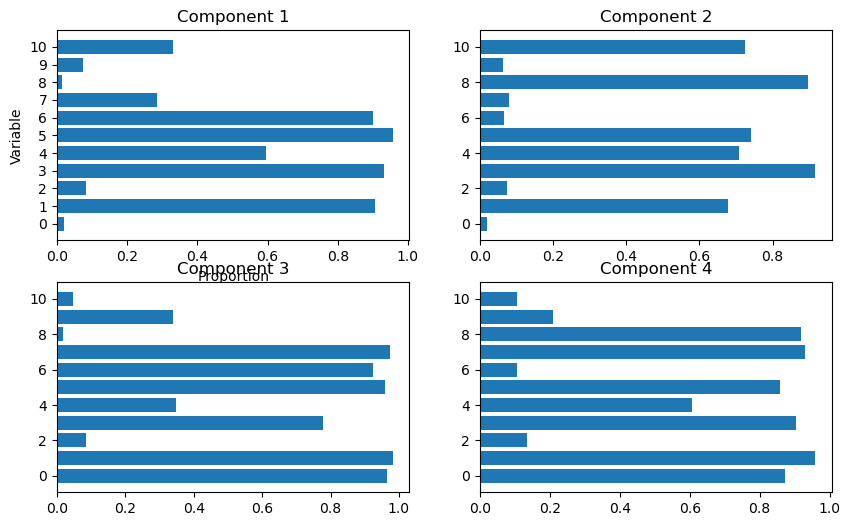

In [24]:
kmeans = MD_km28['4']
labels = kmeans.labels_
MD_mean = pd.DataFrame(MD_x).groupby(labels).mean()

fig, axs = plt.subplots(2, 2, figsize=(10, 6))

for i in range(4):
    axs[i // 2, i % 2].barh(range(MD_mean.shape[1]), MD_mean.iloc[i])
    axs[i // 2, i % 2].set_title(f'Component {i + 1}')

for ax in axs.flat:
    ax.set(ylabel='Variable', xlabel='Proportion')
    ax.set_yticks(range(MD_mean.shape[1]))
    ax.set_yticklabels(MD_x.columns)

for ax in axs.flat:
    ax.label_outer()

fig.suptitle('Segment Profiles')
fig.tight_layout()
plt.show()


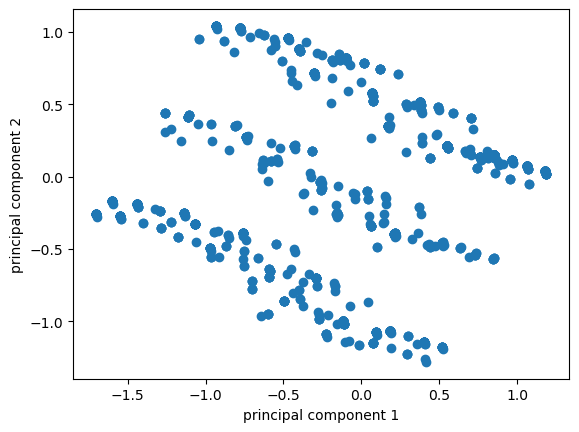

In [27]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(MD_x)

pca = PCA(n_components=2)
MD_pca = pca.fit_transform(MD_x)

fig, ax = plt.subplots()

ax.scatter(MD_pca[:, 0], MD_pca[:, 1])
ax.set_xlabel('principal component 1')
ax.set_ylabel('principal component 2')
plt.show()